Dataset Loaded Successfully!
   label                                            message
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro... 

Model Evaluation Results:
Accuracy: 0.97

Classification Report:
               precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       966
        Spam       1.00      0.78      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



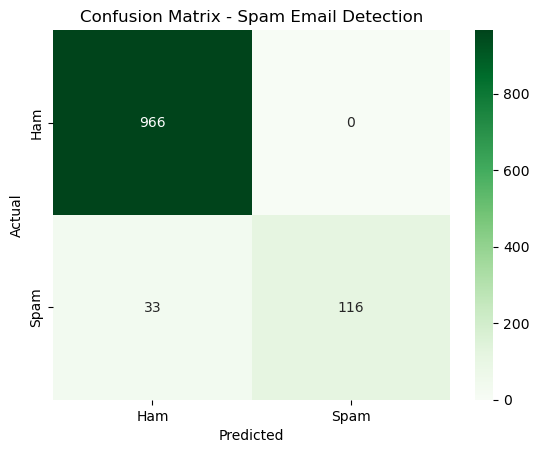

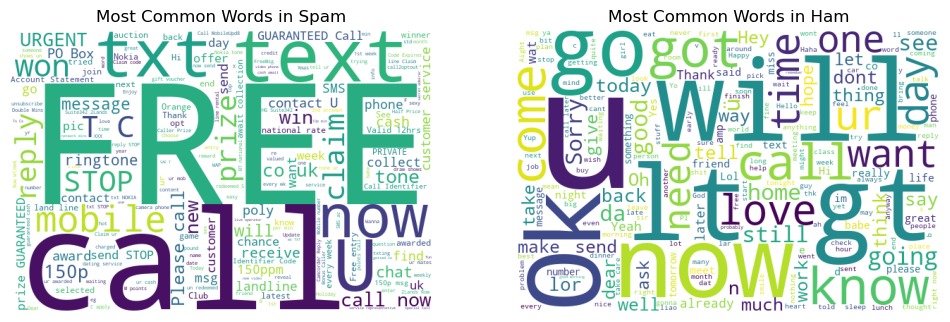


Sample Email Text:
 There is os called ubandu which will run without installing in hard disk...you can use that os to copy the important files in system and give it to repair shop..
Actual Label: Ham
Model Prediction: Ham


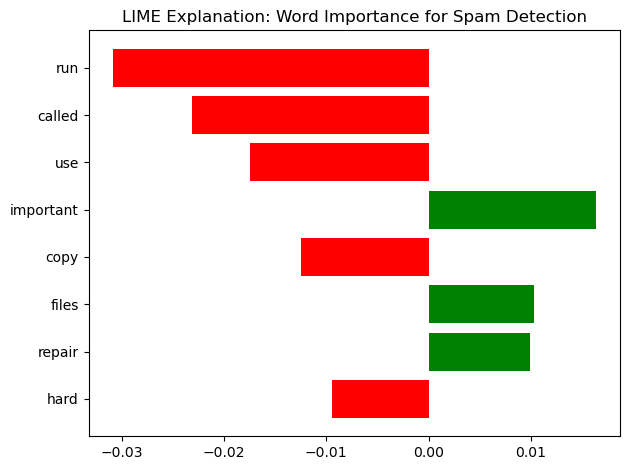


Test Custom Emails:
'Congratulations! You have won a free prize. Click here to claim now!' → Prediction: Spam
'Hey, are we still meeting for lunch tomorrow?' → Prediction: Ham
'Urgent! Your account has been compromised. Verify immediately!' → Prediction: Spam


In [1]:
# ============================================================
# Project: Spam Email Detection with LIME Explainability
# ============================================================

# Install dependencies (uncomment if needed)
# %pip install scikit-learn pandas numpy lime matplotlib seaborn wordcloud

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lime.lime_text import LimeTextExplainer
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

# ------------------------------------------------------------
# 1. Load Dataset
# ------------------------------------------------------------
url = "https://raw.githubusercontent.com/justmarkham/DAT8/master/data/sms.tsv"
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

print("Dataset Loaded Successfully!")
print(df.head(), "\n")

# ------------------------------------------------------------
# 2. Split into Train/Test
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    df['message'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# ------------------------------------------------------------
# 3. Text Vectorization (TF-IDF)
# ------------------------------------------------------------
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# ------------------------------------------------------------
# 4. Train Model
# ------------------------------------------------------------
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# ------------------------------------------------------------
# 5. Evaluate Model
# ------------------------------------------------------------
y_pred = model.predict(X_test_tfidf)
print("Model Evaluation Results:")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title("Confusion Matrix - Spam Email Detection")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ------------------------------------------------------------
# 6. WordCloud Visualization
# ------------------------------------------------------------
spam_words = " ".join(df[df['label']==1]['message'])
ham_words = " ".join(df[df['label']==0]['message'])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=600, height=400, background_color='white').generate(spam_words))
plt.title("Most Common Words in Spam")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=600, height=400, background_color='white').generate(ham_words))
plt.title("Most Common Words in Ham")
plt.axis("off")
plt.show()

# ------------------------------------------------------------
# 7. LIME Explainability
# ------------------------------------------------------------
# Define a function compatible with LIME
class_names = ['Ham', 'Spam']
def predict_proba(texts):
    transformed = vectorizer.transform(texts)
    return np.array([1 - model.predict_proba(transformed)[:,1], model.predict_proba(transformed)[:,1]]).T

# Choose a sample test email
sample_idx = 10
sample_text = X_test.iloc[sample_idx]
print("\nSample Email Text:\n", sample_text)
print("Actual Label:", "Spam" if y_test.iloc[sample_idx]==1 else "Ham")
print("Model Prediction:", "Spam" if model.predict(vectorizer.transform([sample_text]))[0]==1 else "Ham")

# Initialize LIME explainer
explainer = LimeTextExplainer(class_names=class_names)

# Generate explanation
exp = explainer.explain_instance(sample_text, predict_proba, num_features=8)
exp.show_in_notebook(text=sample_text)

# Plot LIME explanation as bar chart
fig = exp.as_pyplot_figure()
plt.title("LIME Explanation: Word Importance for Spam Detection")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 8. Predict Custom Emails
# ------------------------------------------------------------
def predict_email(text):
    text_tfidf = vectorizer.transform([text])
    pred = model.predict(text_tfidf)[0]
    return "Spam" if pred == 1 else "Ham"

print("\nTest Custom Emails:")
samples = [
    "Congratulations! You have won a free prize. Click here to claim now!",
    "Hey, are we still meeting for lunch tomorrow?",
    "Urgent! Your account has been compromised. Verify immediately!"
]

for msg in samples:
    print(f"'{msg}' → Prediction: {predict_email(msg)}")